In [17]:
import numpy as np
import pandas as pd
import scipy

import cvxopt.solvers
import logging

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Methods implementation

### Kernels

In [18]:
def kernel(w, x, type='linear', sigma=1, r=0, d=1):
    if type == 'linear':
        return np.dot(w,x)
    
    elif type == 'polynomial':
        return (sigma * np.dot(w,x) + r) ** d
    
    elif type == 'radial':
        return exp(- sigma * np.linalg.norm(w - x) ** 2)
    
    elif type == 'gaussian':
        return exp( np.linalg.norm(w - x) ** 2 / (2 * sigma ** 2) )
    
    else:
        print('error: incorrect kernel type')
        return
    return 

### SVM (Support Vector Machines)

In [19]:
def M(y, x, w, w0, kernel_type, sigma, r, d):
    return y * (kernel(w, x, kernel_type) - w0) 

def ksi(y, x, w, w0, kernel_type, sigma, r, d):
    return max(0,1 - M(y, x, w, w0, kernel_type, sigma, r, d))

def support_vector_machines_classifier(X, y, w_init=None, C=1,
                   kernel_type='linear', sigma=1, r=0, d=1):
    if(w_init == None):
        w_init = np.zeros(X.shape[1] + 1)
        
    hinge_loss = lambda w: np.array([ksi(y[i], X[i], w[1:], w[0],
                                         kernel_type, sigma, r, d)
                                     for i in range(len(y))]).sum()
    
    regularization = lambda w: kernel(w[1:], w[1:], kernel_type, sigma, r, d) / (2 * C)
    
    w = scipy.optimize.minimize(lambda w: hinge_loss(w) + regularization(w), w_init).x
    return w

def support_vector_machines_prediction(w, X, kernel_type='linear', sigma=1, r=0, d=1):
    return np.array([sign(kernel(x, w[1:], kernel_type, sigma, r, d)) for x in X - w[0]])

### SVM (Support Vector Machines) from workshop

In [20]:
class Kernel(object):
    @staticmethod
    def linear():
        return lambda x, y: np.inner(x, y)

    @staticmethod
    def gaussian(sigma):
        return lambda x, y: exp( - np.linalg.norm(x - y) ** 2 / (2 * sigma ** 2))

MIN_SUPPORT_VECTOR_MULTIPLIER = 1e-5

class SVMTrainer(object):
    def __init__(self, kernel, c=0.1):
        self._kernel = kernel
        self._c = c
    
    def _kernel_matrix(self, X):
        '''
        X: martix of features

        next step: Get number of samples
        next step: Create zero matrix of quadratic shape of number of samples 
        next step: Calculate kernels
        return:    Return Kernels matrix
        '''
        n_samples = X.shape[0]
        K = np.zeros((n_samples, n_samples))
        print(X)
        for i, x_i in enumerate(X):
            for j, x_j in enumerate(X):
                K[i, j] = self._kernel(x_i, x_j)

        return K

    def _compute_lagrange_multipliers(self, X, y):
        '''
        X: martix of features
        y: vector of labels

        Need to Solve
            min 1/2 x^T P x + q^T x (aplha is x)
            s.t.
                Gx <= h (alpha >= 0)
                Ax = b (y^T * alpha = 0)

        next step: Get number of samples
        next step: Create Kernel matrix by calling _kernel_matrix method
        next step: Create create quadratic term P based on Kernel matrix
        next step: Create linear term q
        next step: Create G, h, A, b
        next step: Solve with - cvxopt.solvers.qp(P, q, G, h, A, b)
        retrun:    Return flatten solution['x']
        '''
        n_samples = X.shape[0]
        K = self._kernel_matrix(X)
        P = cvxopt.matrix(np.outer(y, y) * K)
        q = cvxopt.matrix(-1 * np.ones(n_samples))
        G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
        h = cvxopt.matrix(np.zeros(n_samples))
        A = cvxopt.matrix(y, (1, n_samples))
        b = cvxopt.matrix(0.0)

        # If we want to use regularization
        G_std = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
        h_std = cvxopt.matrix(np.zeros(n_samples))
        G_slack = cvxopt.matrix(np.diag(np.ones(n_samples)))
        h_slack = cvxopt.matrix(np.ones(n_samples) * self._c)
        G = cvxopt.matrix(np.vstack((G_std, G_slack)))
        h = cvxopt.matrix(np.vstack((h_std, h_slack)))

        solution = cvxopt.solvers.qp(P, q, G, h, A, b)
        
        return np.ravel(solution['x'])

    def _create_predictor(self, X, y, lagrange_multipliers):
        '''
        X: martix of features
        y: vector of labels
        lagrange_multipliers: vector of langrange multipliers

        next step: Get non-zero lagrange multipliers indicies
        next step: Get non-zero lagrange multipliers
        next step: Get support vecorts
        next step: Get support vecort labels
        next step: Compute bias (use avg trick)
        retrun   : Return SVMPredictor object
        '''

        support_vector_indices = lagrange_multipliers > MIN_SUPPORT_VECTOR_MULTIPLIER

        support_multipliers = lagrange_multipliers[support_vector_indices]

        support_vectors = X[support_vector_indices]

        support_vector_labels = y[support_vector_indices]

        bias = np.mean(
            [y_k - SVMPredictor(
                    kernel=self._kernel,
                    bias=0.0,
                    weights=support_multipliers,
                    support_vectors=support_vectors,
                    support_vector_labels=support_vector_labels
                ).predict(x_k) for (y_k, x_k) in zip(support_vector_labels, support_vectors)
            ]
        )

        return SVMPredictor(
            kernel=self._kernel,
            bias=0.0,
            weights=support_multipliers,
            support_vectors=support_vectors,
            support_vector_labels=support_vector_labels
        )

    def train(self, X, y):
        '''
        X: martix of features
        y: vector of labels

        next step: Compute lagrange multipliers by calling _compute_lagrange_multipliers method
        return:    Return Predictor object by calling _create_predictor method
        '''
        lagrange_multipliers = self._compute_lagrange_multipliers(X, y)
        return self._create_predictor(X, y, lagrange_multipliers)

class SVMPredictor(object):
    def __init__(self, kernel, bias, weights, 
                 support_vectors, support_vector_labels):
        self._kernel = kernel
        self._bias = bias
        self._weights = weights
        self._support_vectors = support_vectors
        self._support_vector_labels = support_vector_labels

        assert len(support_vectors) == len(support_vector_labels)
        assert len(weights) == len(support_vector_labels)

        logging.info("Bias: %s", self._bias)
        logging.info("Weights: %s", self._weights)
        logging.info("Support vectors: %s", self._support_vectors)
        logging.info("Support vector labels: %s", self._support_vector_labels)

    def predict(self, x):
        '''
        Computes the SVM prediction on the given features x.
        '''
        result = self._bias
        for alpha_i, x_i, y_i in zip(self._weights,
                                 self._support_vectors,
                                 self._support_vector_labels):
            result += alpha_i * y_i * self._kernel(x_i, x)

        return np.sign(result).item()

# Quality check

In [21]:
def accuracy(y, y_pred):
    return np.where(y - y_pred == 0)[0].size / len(y)

#  Visualizing algorithms results

In [22]:
def plot_2f_dataset(data, labels, colors=None): 
    from numpy.random import rand
    data = np.array(data)
    labels = np.array(labels)
    n = len(set(labels))
    if(colors == None):
        colors = ListedColormap([tuple(rand(3)) for i in range(n)])
    pyplot.figure(figsize(5, 5))
    pyplot.scatter(data[:,0], data[:,1], c = labels, cmap = colors)
    plt.show()

In [23]:
def print_result(true, predict, cut = 5):
    #print('w:\n',coef,'\n')
    if len(true) > cut:
        nl = '\n...\n'
    else:
        nl = '\n'
    print('true vs. prediction:\n',np.vstack((true,predict)).T[:cut],nl)
    print('accuracy: ',round(accuracy(true, predict),3))

# Data

### Generate dataset

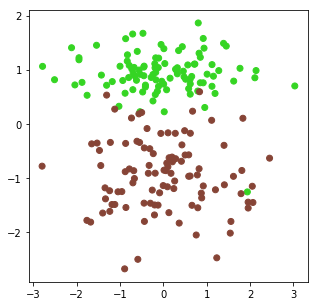

In [43]:
from sklearn import datasets

sample_size = 200
data, target = datasets.make_classification(n_samples=sample_size, n_features=2, 
                                            n_informative=1, n_redundant=0, 
                                            n_repeated=0, n_classes=2, 
                                            n_clusters_per_class=1, 
                                            weights=None, flip_y=0.01, 
                                            class_sep=1.0, hypercube=True, 
                                            shift=0.0, scale=1.0, 
                                            shuffle=True, random_state=1)
target[target == 0] = -1

plot_2f_dataset(data, target)

### Split dataset into train & test samples

In [44]:
from sklearn import cross_validation as cross_val

train_data, test_data, \
train_labels, test_labels = cross_val.train_test_split(data, target,
                                                       test_size = 0.3)

In [45]:
print('train_data: \n',train_data[:5],'\n...\n')
print('train_labels: \n',train_labels[:5],'...')

train_data: 
 [[-0.86778722 -0.3613089 ]
 [ 0.10622272 -0.79181859]
 [ 0.20183018 -0.61339268]
 [ 0.49233656 -0.12603819]
 [-0.8301719   1.15856878]] 
...

train_labels: 
 [-1 -1 -1 -1  1] ...


### Run model and output

### Own

true vs. prediction:
 [[ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [-1. -1.]
 [ 1.  1.]
 [ 1.  1.]
 [-1. -1.]
 [-1. -1.]
 [-1. -1.]
 [-1. -1.]] 
...

accuracy:  1.0


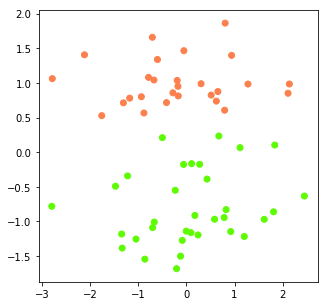

In [46]:
w_init = None
C = 2
kernel_type = 'linear'
sigma = 2
r = 2
d = 1

w = support_vector_machines_classifier(train_data, train_labels, w_init, C, kernel_type, sigma, r, d)
test_labels_predict = support_vector_machines_prediction(w, test_data, kernel_type, sigma, r, d)

print_result(test_labels, test_labels_predict, cut = 10)
if train_data.shape[1] == 2 and (train_data.dtype.type == np.float64
                                 or train_data.dtype.type == np.int64):
    #plot_2f_dataset(train_data, train_labels_predict)
    plot_2f_dataset(test_data, test_labels_predict)

In [57]:
train_labels = train_labels.reshape((len(train_labels),1))
train_labels.shape, train_data.shape

((140, 1), (140, 2))

In [65]:
num_samples=140
num_features=2
grid_size=20
train_data2 = np.matrix(np.random.normal(size=num_samples * num_features)
                        .reshape(num_samples, num_features))
train_labels2 = 2 * (train_data2.sum(axis=1) > 0) - 1.0
train_labels2.shape, train_data.shape

((140, 1), (140, 2))

In [66]:
trainer = SVMTrainer(Kernel.linear())
predictor = trainer.train(train_data2, train_labels2)
#plot(predictor, train_data, train_labels, grid_size)

[[  8.61791154e-01   4.08576719e-01]
 [  5.02639393e-01   1.39023638e+00]
 [  7.96557383e-01  -1.52837569e+00]
 [ -1.17789726e+00  -1.34234380e+00]
 [ -5.16647276e-01   3.93065591e-01]
 [ -7.45622825e-01  -1.15428382e+00]
 [  2.11419318e-03   1.91517476e-01]
 [ -1.26131411e+00   1.57941138e+00]
 [ -1.26713645e+00  -6.51965054e-01]
 [  1.82013592e-01  -5.11635510e-01]
 [ -4.21121534e-01   1.99002611e+00]
 [  5.23707646e-01   1.34036559e+00]
 [ -2.58421123e-01   4.10356482e-01]
 [ -3.10295864e-01  -1.30594946e-01]
 [  3.26762444e-01   1.42302296e+00]
 [ -4.07292429e-01  -5.82593672e-01]
 [ -2.25944818e-01   2.74552948e+00]
 [  1.53017360e+00  -1.00097275e+00]
 [  1.97671739e+00   5.79607708e-01]
 [  1.75917140e+00   5.51902741e-01]
 [ -4.15883941e-01   8.81804803e-01]
 [  7.70457453e-01   9.66909690e-02]
 [  9.55141065e-01  -1.41546471e+00]
 [ -1.36987038e+00  -1.02161433e+00]
 [ -1.66720371e+00  -1.10960595e+00]
 [ -1.33086381e+00  -2.03304911e-01]
 [ -1.14788941e+00   8.94652584e-01]
 

### sklearn.cluster.SVM for check

true vs. prediction:
 [[ 1  1]
 [ 1  1]
 [ 1  1]
 [ 1  1]
 [-1 -1]] 
...

accuracy:  0.983


/Users/Yaroslava/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


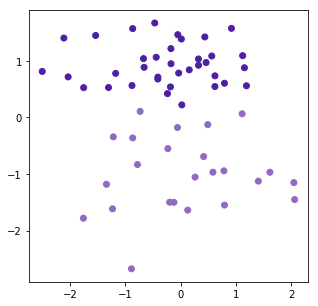

In [41]:
from sklearn import svm

SVM_classifier = svm.LinearSVC()
SVM_classifier.fit(train_data,train_labels)
print_result(test_labels, SVM_classifier.predict(test_data))
if train_data.shape[1] == 2 and (train_data.dtype.type == np.float64
                                 or train_data.dtype.type == np.int64):
    #plot_2f_dataset(train_data, SVM_classifier.predict(train_data))
    plot_2f_dataset(test_data, SVM_classifier.predict(test_data))